<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверим *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score, 
    recall_score,
    precision_recall_curve,
    roc_curve,
    roc_auc_score
)
import warnings

In [8]:
data = pd.read_csv('/datasets/Churn.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [10]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Есть пропуски в столбце Tenure. Скорее всего это те, кто с банком меньше года. Поэтому заполним нулями. И изменим тип данных - сделаем целые числа.

In [11]:
tenure_med = data['Tenure'].median()
data['Tenure'] = data['Tenure'].fillna(tenure_med)
data['Tenure'] = data['Tenure'].astype('int')
data['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

Признаки - CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary - все, кроме индекса строки, уникального идентификатора клиента и фамилии.

Уберем ненужные столбцы и пропустим получившийся датасет через прямое кодирование (порядковое не подходит для всех наших столбцов), чтобы преобразовать категориальные признаки в числовые.

In [12]:
data_new = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data_ohe = pd.get_dummies(data_new, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Так как в данных присутствуют количественные признаки с разными разбросами значений, нужно применить масштабирование. Сначала разделим данные на обучающую, валидационную и тестовую выборки.

In [13]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

#исходную выборку нужно разделить на обучающую, тестовую и валидационную в отношении 3:1:1
#сначала разделим на обучающую и валидационно-тестовую 3:2
features_train, features_val_test, target_train, target_val_test = train_test_split(
    features, target, test_size=0.4, random_state=1234, stratify=target)
#теперь разделим валидационно-тестовую пополам
features_valid, features_test, target_valid, target_test = train_test_split(
    features_val_test, target_val_test, test_size=0.5, random_state=1234, stratify=target_val_test)

#проверим разбиение
print(features_train.shape, target_train.shape, features_valid.shape, 
      target_valid.shape, features_test.shape, target_test.shape)

(6000, 11) (6000,) (2000, 11) (2000,) (2000, 11) (2000,)


In [75]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

#cоздаем объект структуры StandardScaler() и настраиваем его на обучающих данных
#в переменной numeric список численных признаков

scaler = StandardScaler()
scaler.fit(features_train[numeric])

#масштабируем сначала тренировочную выборку
features_train[numeric] = scaler.transform(features_train[numeric])

features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5303,-0.166171,-1.331968,1.440870,-1.233248,0.806716,1,1,-1.589297,0,1,1
2235,-0.020988,1.631714,0.356059,1.302244,0.806716,1,0,0.727682,0,1,0
519,0.590857,1.822920,0.356059,0.210003,-0.909701,0,1,0.474278,0,0,1
9778,0.850113,0.388880,1.440870,-1.233248,0.806716,1,0,1.463385,0,0,0
3007,-0.498019,-0.567147,-0.005545,1.417220,-0.909701,0,1,1.420958,0,0,1


In [74]:
#масштабируем теперь валидационную выборку
features_valid[numeric] = scaler.transform(features_valid[numeric])

features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6342,-6.748327,-3.739696,-1.161782,-1.233240,-4.187544,1,0,-1.732894,0,0,0
7447,-6.742412,-3.803675,-1.423296,-1.233231,-1.241457,1,1,-1.732887,1,0,1
8355,-6.756607,-3.675717,-1.946325,-1.233238,-4.187544,1,1,-1.732917,0,1,1
355,-6.752843,-3.803675,-1.815567,-1.233267,-1.241457,1,0,-1.732872,0,0,1
3649,-6.746606,-3.703137,-1.946325,-1.233228,-4.187544,1,1,-1.732893,0,0,1


In [73]:
# и масштабируем тестовую выборку
features_test[numeric] = scaler.transform(features_test[numeric])

features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5081,-6.811534,-4.112553,-2.689654,-1.233267,-19.470496,1,1,-1.732921,0,0,0
7563,-6.811534,-4.110715,-2.672557,-1.233267,-10.791070,0,1,-1.732921,0,0,1
4799,-6.811534,-4.110798,-2.775141,-1.233267,-19.470496,0,0,-1.732921,0,0,1
5814,-6.811534,-4.111801,-2.775141,-1.233267,-10.791070,1,1,-1.732921,1,0,0
4844,-6.811533,-4.112135,-2.758044,-1.233267,-10.791070,0,0,-1.732921,1,0,0


Теперь выборки готовы к дальнейшей работе. Приступим к исследованию задачи моделями машинного обучения.

## Исследование задачи

Для исследования будем обучать три модели. Дерево решений, случайный лес и логистическая регрессия. 

Проверим баланс классов в валидационной и тренировочной выборках.

In [19]:
target_train.value_counts(normalize = 1)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

In [20]:
target_valid.value_counts(normalize = 1)

0    0.7965
1    0.2035
Name: Exited, dtype: float64

Наблюдается заметный дисбаланс класов. Ответы 0 - 80% , 1 - 20%.

Можно ожидать, что результаты предсказаний моделей будут сильно склоняться к одному варианту ответов.

Начнем обучение моделей без учета дисбаланса.

In [31]:
#подберем параметр глубины для модели дерева решений
best_model_DTC = None
best_result_DTC = 0.59
best_depth_DTC = 0

for depth in range(1, 6):
    model_DTC = DecisionTreeClassifier(random_state=1234, max_depth=depth)
    model_DTC.fit(features_train, target_train)
    DTC_prediction = model_DTC.predict(features_valid) 
    result_DTC = f1_score(target_valid, DTC_prediction) 
    if result_DTC > best_result_DTC:
        best_model_DTC = model_DTC
        best_result_DTC = result_DTC
        best_depth_DTC = depth
        
print("F1 лучшей модели дерева решений на валидационной выборке:", best_result_DTC, 'Лучшая глубина', best_depth_DTC)

F1 лучшей модели дерева решений на валидационной выборке: 0.6188466947960619 Лучшая глубина 5


In [36]:
#обучим модель в подобранным параметром и получим предсказания

model_DTC = DecisionTreeClassifier(random_state=1234, max_depth=5)
model_DTC.fit(features_train, target_train)
DTC_prediction = model_DTC.predict(features_valid)

In [37]:
#матрица ошибок для дерева решений

confusion_matrix(target_valid, DTC_prediction)

array([[1509,   84],
       [ 187,  220]])

Дерево решений склонно выдавать позитивные предсказания, очень высокое количество ложно позитивных предсказания (FP).
Изучим полноту, точность и F1-меру.

In [42]:
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))

In [43]:
#полнота, точность и F1-мера для дерева решений
rec_prec_f1(target_valid, DTC_prediction)

Полнота 0.5405405405405406
Точность 0.7236842105263158
F1-мера 0.6188466947960619


Значние F1- меры высокое, но вот полнота и точность недостаточны.

In [35]:
# подберем параметры для модели случайного леса
best_model_RFC = None
best_result_RFC = 0.59
best_est_RFC = 0
best_depth_RFC = 0

for est in range(10, 151, 10):
    for depth in range (1, 16):
        model_RFC = RandomForestClassifier(random_state=1234, n_estimators=est, max_depth=depth)
        model_RFC.fit(features_train, target_train)
        RFC_prediction = model_RFC.predict(features_valid)
        result_RFC = f1_score(target_valid, RFC_prediction)
        if result_RFC > best_result_RFC:
            best_model_RFC = model_RFC
            best_result_RFC = result_RFC
            best_est_RFC = est
            best_depth_RFC = depth

print('F1 лучшей модели случайного леса на валидационной выборке:', best_result_RFC, 
      'Количество деревьев:', best_est_RFC, 
      'Максимальная глубина:', best_depth_RFC)

F1 лучшей модели случайного леса на валидационной выборке: 0.6253776435045317 Количество деревьев: 140 Максимальная глубина: 13


In [39]:
#обучим модель с подобранными параметрами

model_RFC = RandomForestClassifier(random_state=1234, n_estimators=140, max_depth=13)
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)

In [40]:
#матрица ошибок для случайного леса
confusion_matrix(target_valid, RFC_prediction)

array([[1545,   48],
       [ 200,  207]])

Случайный лес выдает примерно равную пропорцию позитивных и негативных предсказаний, здесь заметно больше качественных предсказаний, но также сильно склоняется к ложно позитивным предсказаниям (FP).

In [44]:
#полнота, точность и F1-мера для случайного леса
rec_prec_f1(target_valid, RFC_prediction)

Полнота 0.5085995085995086
Точность 0.8117647058823529
F1-мера 0.6253776435045317


Значние F1- меры здесь также выше заданного значения, точность лучше, чем у модели дерева почти на 0.1. А вот полнота очень низкая.

In [46]:
#матрица ошибок для логистической регрессии
model_LgR = LogisticRegression(solver = 'liblinear')
model_LgR.fit(features_train, target_train)
LgR_prediction = model_LgR.predict(features_valid)
confusion_matrix(target_valid, LgR_prediction)

array([[1526,   67],
       [ 313,   94]])

In [47]:
rec_prec_f1(target_valid, LgR_prediction)

Полнота 0.23095823095823095
Точность 0.5838509316770186
F1-мера 0.33098591549295775


Здесь все показатели низкие.

Лучшей моделью был случайный лес. Рассчитаем для него ROC_AUC.

In [49]:
probabilities = model_RFC.predict_proba(features_valid)
probabilities_one_valid = probabilities[:, 1]
print('auc_roc:', roc_auc_score(target_valid, probabilities_one_valid))

auc_roc: 0.8605832334645893


Итак лучшей моделью оказался случайный лес с параметрами random_state=1234, n_estimators=140, max_depth=13. Полнота не дотягивает до хорошей модели. Будем пробовать убрать дисбаланс.

Полнота 0.5085995085995086

Точность 0.8117647058823529

F1-мера 0.6253776435045317

auc_roc: 0.8605832334645893

## Борьба с дисбалансом

Как мы выяснили ранее в нашей выборке отрицательны ответов около 80% , положитительных примерно 20%.
Нам необходмо увеличить количество положительных ответов в 4 раза для достижения баланса.

In [52]:
#создадим функцию для увеличения класса в выборке 
def upsample(features, target, repeat, upsampled_сlass):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if upsampled_сlass == 0:
        features_upsampled = pd.concat([features_zeros]* repeat + [features_ones] )
        target_upsampled = pd.concat([target_zeros]* repeat + [target_ones] )
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
        
    elif upsampled_сlass == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    else:
        features_upsampled = 0
        target_upsampled = 0  
        
        
       
    return features_upsampled, target_upsampled
    "Функция принимает значение признаков (features[]), целевого признака (target[]), repeat(int / float), "
    " класс который будет увеличен (upsampled_сlass (0 or 1))"

In [53]:
#применим функцию upsample 
#увеличим количество положительных ответов в 4 раза
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

1    0.50569
0    0.49431
Name: Exited, dtype: float64
(9666,)


Мы получили сбалансированное количество классов, перейдем к обучению моеделей на новых данных.

Проверим как изменилось качество ответов. Так как мы меняем обучающие данные, то будем заново подбирать параметры моделей.

In [55]:
#подберем параметр глубины для модели дерева решений на увеличенной выборке
best_model_DTC = None
best_result_DTC = 0.59
best_depth_DTC = 0

for depth in range(1, 10):
    model_DTC = DecisionTreeClassifier(random_state=1234, max_depth=depth)
    model_DTC.fit(features_train_upsampled, target_train_upsampled)
    DTC_prediction = model_DTC.predict(features_valid) 
    result_DTC = f1_score(target_valid, DTC_prediction) 
    if result_DTC > best_result_DTC:
        best_model_DTC = model_DTC
        best_result_DTC = result_DTC
        best_depth_DTC = depth
        
print("F1 лучшей модели дерева решений на валидационной выборке:", best_result_DTC, 'Лучшая глубина', best_depth_DTC)

F1 лучшей модели дерева решений на валидационной выборке: 0.59 Лучшая глубина 0


Получили, что желаемой отметки F1-меры на дереве решений нам не достичь.

In [56]:
# подберем параметры для модели случайного леса на увеличенной выборке
best_model_RFC = None
best_result_RFC = 0.59
best_est_RFC = 0
best_depth_RFC = 0

for est in range(10, 151, 10):
    for depth in range (1, 16):
        model_RFC = RandomForestClassifier(random_state=1234, n_estimators=est, max_depth=depth)
        model_RFC.fit(features_train_upsampled, target_train_upsampled)
        RFC_prediction = model_RFC.predict(features_valid)
        result_RFC = f1_score(target_valid, RFC_prediction)
        if result_RFC > best_result_RFC:
            best_model_RFC = model_RFC
            best_result_RFC = result_RFC
            best_est_RFC = est
            best_depth_RFC = depth

print('F1 лучшей модели случайного леса на валидационной выборке:', best_result_RFC, 
      'Количество деревьев:', best_est_RFC, 
      'Максимальная глубина:', best_depth_RFC)

F1 лучшей модели случайного леса на валидационной выборке: 0.6370192307692308 Количество деревьев: 130 Максимальная глубина: 13


Здесь получили хороший показатель F1-меры в 0.64 на модели с параметрами random_state=1234, n_estimators=130, max_depth=13.

In [58]:
model_RFC_upsampled = RandomForestClassifier(random_state=1234, n_estimators=130, max_depth=13)
model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled)
RFC_prediction_upsampled = model_RFC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, RFC_prediction_upsampled)

Полнота 0.6511056511056511
Точность 0.6235294117647059
F1-мера 0.6370192307692308


У этой модели случайного леса мы наблюдаем увеличение полноты, но снижение точности. F1-мера достаточно высокая.

In [59]:
#Логистическая регрессия
model_LgR_upsampled = LogisticRegression(solver = 'liblinear')
model_LgR_upsampled.fit(features_train_upsampled, target_train_upsampled)
LgR_prediction_upsampled = model_LgR_upsampled.predict(features_valid)
rec_prec_f1(target_valid, LgR_prediction_upsampled)

Полнота 0.7174447174447175
Точность 0.38522427440633245
F1-мера 0.5012875536480687


Здесь F1-мера не дотягивает до нужного нам уровня в 0.59. Модель не подходит.

Итак, лучшие показатели мы получили в модели случайного леса, обученной на увеличенной выборке, с параметрами random_state=1234, n_estimators=130, max_depth=13. Рассчитаем для этой модели AUC-ROC.

In [62]:
probabilities_upsampled = model_RFC_upsampled.predict_proba(features_valid)
probabilities_one_valid_upsampled = probabilities_upsampled[:, 1]
print('auc_roc:', roc_auc_score(target_valid, probabilities_one_valid_upsampled))

auc_roc: 0.8555257877291775


AUC-ROC чуть снизился, но остался на высоком уровне.

Далее попробуем подобрать порог классификации.

In [65]:
for threshold in np.arange(0.4, 0.8, 0.02):
    predicted_valid = probabilities_one_valid_upsampled > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.4f}".format(
        threshold, precision, recall, F1))

Порог = 0.40 | Точность = 0.523, Полнота = 0.742, F1 = 0.6138
Порог = 0.42 | Точность = 0.544, Полнота = 0.717, F1 = 0.6186
Порог = 0.44 | Точность = 0.551, Полнота = 0.690, F1 = 0.6129
Порог = 0.46 | Точность = 0.568, Полнота = 0.676, F1 = 0.6173
Порог = 0.48 | Точность = 0.593, Полнота = 0.663, F1 = 0.6265
Порог = 0.50 | Точность = 0.624, Полнота = 0.651, F1 = 0.6370
Порог = 0.52 | Точность = 0.628, Полнота = 0.622, F1 = 0.6247
Порог = 0.54 | Точность = 0.646, Полнота = 0.604, F1 = 0.6244
Порог = 0.56 | Точность = 0.672, Полнота = 0.585, F1 = 0.6255
Порог = 0.58 | Точность = 0.681, Полнота = 0.572, F1 = 0.6222
Порог = 0.60 | Точность = 0.714, Полнота = 0.558, F1 = 0.6262
Порог = 0.62 | Точность = 0.723, Полнота = 0.550, F1 = 0.6248
Порог = 0.64 | Точность = 0.740, Полнота = 0.523, F1 = 0.6129
Порог = 0.66 | Точность = 0.753, Полнота = 0.494, F1 = 0.5964
Порог = 0.68 | Точность = 0.767, Полнота = 0.469, F1 = 0.5823
Порог = 0.70 | Точность = 0.790, Полнота = 0.445, F1 = 0.5692
Порог = 

Необходимый нам порог классификации 0.5, здесь F1-мера принимает наибольшее значение - 0.6370. Это значение порога по умолчанию, значит оставляем всё без изменений.

Теперь проверим модель на адекватность - сравним с константной.

In [37]:
#Создаем константную модель
target_predict_constant = pd.Series([0]*len(target_valid))
target_predict_constant.value_counts()

0    2000
dtype: int64

In [66]:
#Сравним показатель точности (accuracy_score) константной модели и выбранной нами
print('accuracy_score константой модели:', accuracy_score(target_valid, target_predict_constant))
print('accuracy_score выбранной модели:', accuracy_score(target_valid, RFC_prediction_upsampled))

#Дополнительно сравним AUC-ROC — единственный параметр подающийся сравнению, 
#потому что константная подель содержит только негативные ответы
print('AUC-ROC константой модели:', roc_auc_score(target_valid, target_predict_constant))
print('AUC-ROC выбранной модели:', roc_auc_score(target_valid, RFC_prediction_upsampled))

accuracy_score константой модели: 0.7965
accuracy_score выбранной модели: 0.849
AUC-ROC константой модели: 0.5
AUC-ROC выбранной модели: 0.7753331143161651


Выбранная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.

**Общий вывод:** 

- В первоначальных данных наблюдался значительный дисбаланс (80% ответов целевого признака были негативными и только 20% позитивными).

- Из моделей, обученных на несбалансированной выборке, лучше оказалась модель случайного леса с параметрами (random_state=1234, n_estimators=140, max_depth=13). Но у нее было недостаточно полноты.

- Мы устранили дисбаланс классов в обучающей выборки методом upsampling — увеличили количество значений позитивного класса в 4 раза. Так мы достигли баланса классов в обучающей выборки: 1 = 0.50569, 0 = 0.49431.

- На новых данных все модели показали результат выше, чем на несбалансированной выборке. Лучшие показатели были у модели случайного леса с параметрами (random_state=1234, n_estimators=130, max_depth=13), полнота увеличилась на 0.15:

Полнота 0.6511056511056511

Точность 0.6235294117647059

F1-мера 0.6370192307692308

auc_roc: 0.8555257877291775


- Мы пытались улучших качество модели перебором порогов классификации, но порог был оставлен по умолчанию, так как именно он показал наибольшее значение F1-меры.

- Финальная модель прошла проверку на адекватность в сравнении с контантной моделью:

accuracy_score константой модели: 0.7965

accuracy_score выбранной модели: 0.849

AUC-ROC константой модели: 0.5

AUC-ROC выбранной модели: 0.7753331143161651

## Тестирование модели

In [67]:
model_RFC_upsampled
model_RFC_upsampled_prediction = model_RFC_upsampled.predict(features_test)
rec_prec_f1(target_test, model_RFC_upsampled_prediction)

Полнота 0.625
Точность 0.6115107913669064
F1-мера 0.6181818181818182


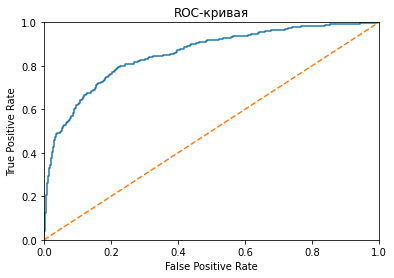

In [68]:
final_model_probabilities_one = model_RFC_upsampled.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_probabilities_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Финальная модель достигла заданой метрики (F1 > 0.59) и показывает адекватные результаты.

Модель характеризуется средним показателем полноты = 0.625, поэтому она с хорошей вероятностью предскажет уход клиента из банка.
Показатель точности тоже не очень высокий = 0.61 — модель верно предсказывает более половины ухода клиентов.

С точки зрения бизнеса полученная модель поможет маркетологам лучше определять килентов, которые могут уйти в ближайшее время. Важно, что модель покрывает большое количество клиентов, в данном случае это важнее чем точность.

Для улучшения модели следует использовать данные, отражающие отношения клиента с банком в динамике.